In [87]:
# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import pandas as pd

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc

 
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from sklearn.metrics import make_scorer
 
from sklearn.metrics import classification_report, accuracy_score
import random
random.seed(100)
 
import time
import pyodbc
print(pyodbc.drivers())
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# mlflow
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine, text

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [2]:
# Loading train test data
tt_data = pd.read_csv('../data/interim/Final_data_train_test.csv')

In [3]:
len(tt_data.columns)

27

In [4]:
tt_data.drop(columns={'Unnamed: 0', 'patient_nbr','gender'}, inplace=True)

In [5]:
tt_data.head()

,encounter_id,race,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_category,admission_category,Specialty_Group,payer_code_group,number_outpatient_log,number_inpatient_log,number_emergency_log,diag_3_cat,Patient_Age
0,12522,Caucasian,13,68.0,2,28.0,8,No,No,0,1,Ch,Yes,0,Urgent,Discharged to Home,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0,Other,90
1,15738,Caucasian,12,33.0,3,18.0,8,No,No,0,1,Ch,Yes,0,Elective,Transfers to Other Healthcare Facilities,Transfers from Other Facilities,Other,Self-Pay/Other,0.0,0.0,0.0,Respiratory,92
2,16680,Caucasian,1,51.0,0,8.0,5,No,No,0,1,Ch,Yes,0,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0,Diabetes,47
3,28236,AfricanAmerican,9,47.0,2,17.0,9,No,No,0,1,No,Yes,1,Emergency,Discharged to Home,Emergency Admission,Other,Self-Pay/Other,0.0,0.0,0.0,Injury,45
4,35754,Caucasian,3,31.0,6,16.0,9,No,No,0,1,No,Yes,1,Urgent,Discharged to Home,Physician Referral,Other,Self-Pay/Other,0.0,0.0,0.0,Diabetes,52


In [6]:
tt_data.columns

Index(['encounter_id', 'race', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'insulin', 'change',
       'diabetesMed', 'readmitted', 'admission_type_desc',
       'discharge_category', 'admission_category', 'Specialty_Group',
       'payer_code_group', 'number_outpatient_log', 'number_inpatient_log',
       'number_emergency_log', 'diag_3_cat', 'Patient_Age'],
      dtype='object')

### Setting up SQL Database


In [7]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [8]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - df: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        df = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return df  

In [9]:
server = 'ROHIT'     
database = 'DiabetesData'  
username = 'rohit_kosamkar'       
password = 'September@2024' 

In [10]:
# Establish connection with database
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


### Set Up MLflow Tracking with SQL Database

In [11]:
import mlflow
import mlflow.sklearn
from sqlalchemy import create_engine

try:
    # Set MLflow Tracking URI using SQL Server and Windows Authentication
    mlflow.set_tracking_uri("mssql+pyodbc://ROHIT/DiabetesData?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")
 
    # Setting up the Name of experiment
    mlflow.set_experiment("DiabetesPatientReadmissionPrediction")
except Exception as e:
    print(f"Connection failed: {e}")

2024/10/19 21:05:24 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/10/19 21:05:24 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl MSSQLImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Context impl MSSQLImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.


In [12]:
## Let's check the onnection status
# Setting up mlflow URI
mlflow_tracking_uri = (
    r"mssql+pyodbc://ROHIT/DiabetesData"
    "?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)
 
# Setting up the MLflow Tracking URI
mlflow.set_tracking_uri(mlflow_tracking_uri)
 
try:
    # SQLAlchemy engine
    engine = create_engine(mlflow_tracking_uri)
 
    # Testing the connection by running a query
    with engine.connect() as connection:
        # Using the text() function for SQL statement
        query = text("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES")
        result = connection.execute(query)
 
        # Fetching all the results 
        tables = result.fetchall()
 
        # list of tables
        print("Connection successful! Here are the tables in the database:")
        for table in tables:
            print(table[0])
 
    # Name the experiment (if connection is successful)
    mlflow.set_experiment("DiabetesPatientReadmissionPrediction")
 
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Here are the tables in the database:
trace_request_metadata
patient_data_train_test
patient_data_validation
patient_readmission_status
admissionsource
admissionType
discharge_disposition
experiments
runs
tags
metrics
params
alembic_version
experiment_tags
latest_metrics
registered_models
model_versions
registered_model_tags
model_version_tags
registered_model_aliases
datasets
inputs
input_tags
trace_info
trace_tags


### One-hot encoding for categorical columns

In [11]:
tt_data.select_dtypes(include='object').columns

Index(['race', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'Specialty_Group', 'payer_code_group', 'diag_3_cat'],
      dtype='object')

In [60]:
len(tt_data.columns)

24

In [12]:
### One-hot encoding
cat_cols = ['race', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'Specialty_Group', 'payer_code_group', 'diag_3_cat']

data_encoded = pd.get_dummies(tt_data, columns = cat_cols, drop_first=True)
data_encoded.shape

(83017, 48)

In [13]:
data_encoded.head()

,encounter_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,metformin,insulin,readmitted,number_outpatient_log,number_inpatient_log,number_emergency_log,Patient_Age,race_Asian,race_Caucasian,race_Hispanic,race_Other,max_glu_serum_>300,max_glu_serum_No,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_No,A1Cresult_Norm,change_No,diabetesMed_Yes,admission_type_desc_Emergency,admission_type_desc_Other,admission_type_desc_Urgent,discharge_category_Discharged to Home,discharge_category_Other,discharge_category_Transfers to Other Healthcare Facilities,admission_category_Other,admission_category_Physician Referral,admission_category_Transfers from Other Facilities,Specialty_Group_Family/General Practice,Specialty_Group_Internal Medicine,Specialty_Group_Other,Specialty_Group_Surgery,payer_code_group_Private Insurance,payer_code_group_Self-Pay/Other,diag_3_cat_Diabetes,diag_3_cat_Digestive,diag_3_cat_Genitourinary,diag_3_cat_Injury,diag_3_cat_Musculoskeletal,diag_3_cat_Neoplasms,diag_3_cat_Other,diag_3_cat_Respiratory
0,12522,13,68.0,2,28.0,8,0,1,0,0.0,0.0,0.0,90,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False
1,15738,12,33.0,3,18.0,8,0,1,0,0.0,0.0,0.0,92,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True
2,16680,1,51.0,0,8.0,5,0,1,0,0.0,0.0,0.0,47,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False
3,28236,9,47.0,2,17.0,9,0,1,1,0.0,0.0,0.0,45,False,False,False,False,False,True,False,False,True,False,True,True,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
4,35754,3,31.0,6,16.0,9,0,1,1,0.0,0.0,0.0,52,False,True,False,False,False,True,False,False,True,False,True,True,False,False,True,True,False,False,False,True,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False


In [14]:
X = data_encoded.drop(columns='readmitted')

y = data_encoded['readmitted']

### Train Test Split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (58111, 47)
X_test: (24906, 47)
y_train: (58111,)
y_test: (24906,)


In [18]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [19]:
# Hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    "Decision Tree Classifier": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Random Forest Classifier": {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }
}

In [20]:
def get_feature_importance(model, feature_names):
    """
    Extract feature importance or coefficients from the model.
    - Supports tree-based models (RandomForest, XGBoost) and linear models (LogisticRegression).
    """
    if hasattr(model, 'coef_'):  # For linear models
        importance = np.abs(model.coef_[0])  # Use absolute value of coefficients
    elif hasattr(model, 'feature_importances_'):  # For tree-based models
        importance = model.feature_importances_
    else:
        return None  

    # DataFrame for feature importance
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

In [23]:
feature_names = X_train.iloc[:,1:].columns.tolist()

In [25]:
# feature_names

### Mlflow Tracking

In [44]:
def evaluate_models(models, param_grids, X_train, X_test, y_train, y_test, feature_names, experiment_name="Model Comparison", run_tags=None):
    """
    Evaluates models, logs comprehensive metrics in MLflow, and manages experiment metadata.
    
    Parameters:
    - models: Dictionary of models to evaluate.
    - param_grids: Dictionary of hyperparameters.
    - X_train, X_test, y_train, y_test: Datasets.
    - feature_names: List of feature names for importance extraction.
    - experiment_name: Name of the MLflow experiment.
    - run_tags: Optional tags for each run (dict).
    """
    mlflow.set_experiment(experiment_name)  
    results = []

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        start_time = time.time()

        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grids[model_name], 
            scoring='recall', 
            cv=3, 
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        train_metrics = {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred, average='weighted'),
            'recall': recall_score(y_train, y_train_pred, average='weighted'),
            'f1_score': f1_score(y_train, y_train_pred, average='weighted')
        }

        test_metrics = {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, average='weighted'),
            'recall': recall_score(y_test, y_test_pred, average='weighted'),
            'f1_score': f1_score(y_test, y_test_pred, average='weighted')
        }

        time_taken = time.time() - start_time
        feature_importance = get_feature_importance(best_model, feature_names)

        with mlflow.start_run(run_name=model_name) as run:
            # Log parameters and metrics
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metrics({**train_metrics, **test_metrics, 'time_taken': time_taken})

            # # Log input datasets 
            # mlflow.log_artifact("X_train.csv")
            # mlflow.log_artifact("X_test.csv")

            # Log feature importance if available
            if feature_importance is not None:
                feature_importance_file = f"../mlruns/{model_name}_feature_importance.csv"
                feature_importance.to_csv(feature_importance_file, index=False)
                mlflow.log_artifact(feature_importance_file)

            # Log tags for additional metadata
            if run_tags:
                mlflow.set_tags(run_tags)

            # Log the model itself
            mlflow.sklearn.log_model(best_model, model_name)

            # Register the model in MLflow Model Registry
            mlflow.register_model(f"../mlruns/runs:/{run.info.run_id}/{model_name}", model_name)

        results.append({
            'model': model_name,
            'best_params': grid_search.best_params_,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'time_taken': time_taken
        })

        print(f"{model_name} completed in {time_taken:.2f} seconds with test recall: {test_metrics['recall']:.4f}")

    return results

In [45]:
results = evaluate_models(
    models, 
    param_grids, 
    X_train.drop(['encounter_id'], axis=1), X_test.drop(['encounter_id'], axis=1), y_train, y_test, 
    feature_names,
    experiment_name="Model Comparison Experiment",
    run_tags={"author": "Rohit", "task": "Recall Optimization"}
)

Evaluating Logistic Regression...


2024/10/20 00:10:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression' already exists. Creating a new version of this model...
Created version '4' of model 'Logistic Regression'.


Logistic Regression completed in 41.69 seconds with test recall: 0.6242
Evaluating Decision Tree Classifier...


2024/10/20 00:10:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Decision Tree Classifier' already exists. Creating a new version of this model...
Created version '4' of model 'Decision Tree Classifier'.


Decision Tree Classifier completed in 8.10 seconds with test recall: 0.6137
Evaluating Random Forest Classifier...


KeyboardInterrupt: 

### Best Model

In [37]:
## Taking Best Parameters for Random Forest Classifier
start_time = time.time()

model = LogisticRegression(C= 0.1, solver= 'liblinear', penalty= 'l1')
# model = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf= 4, min_samples_split=20,random_state=42)
model.fit(X_train.drop(['encounter_id'], axis=1), y_train)

# Predictions
y_pred_train = model.predict(X_train.drop(['encounter_id'], axis=1))
y_pred_test = model.predict(X_test.drop(['encounter_id'], axis=1))

end_time = time.time()
# Time taken
execution_time = end_time - start_time
print('Execution time: ', execution_time)

# Metrics for Training Data
print("\nRandom Forest Classifier Training Report:")
print(classification_report(y_train, y_pred_train))
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Training Precision: {precision_score(y_train, y_pred_train)}")
print(f"Training Recall: {recall_score(y_train, y_pred_train)}")
print(f"Training F1 Score: {f1_score(y_train, y_pred_train)}")

# Metrics for Test Data
print("\nRandom Forest Classifier Test Report:")
print(classification_report(y_test, y_pred_test))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Test Precision: {precision_score(y_test, y_pred_test)}")
print(f"Test Recall: {recall_score(y_test, y_pred_test)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_test)}")

Execution time:  3.372541904449463

Random Forest Classifier Training Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.66     29828
           1       0.64      0.53      0.58     28283

    accuracy                           0.63     58111
   macro avg       0.63      0.62      0.62     58111
weighted avg       0.63      0.63      0.62     58111

Training Accuracy: 0.6265423069642581
Training Precision: 0.6420584552950827
Training Recall: 0.5258282360428526
Training F1 Score: 0.5781596236830852

Random Forest Classifier Test Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     12784
           1       0.64      0.52      0.58     12122

    accuracy                           0.62     24906
   macro avg       0.63      0.62      0.62     24906
weighted avg       0.63      0.62      0.62     24906

Test Accuracy: 0.6237452822613025
Test Precision: 0.6382551010151774
Test Reca

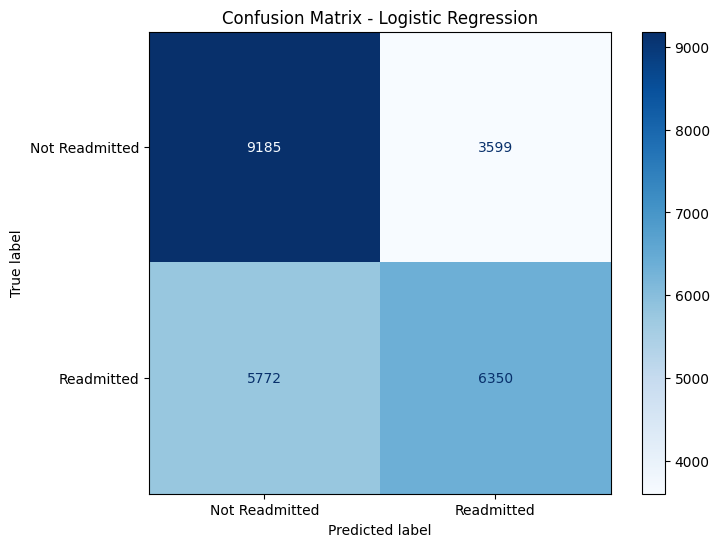

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Create display with custom class labels: 0 = Not Fraud, 1 = Fraud
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Readmitted', 'Readmitted'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
## Feature importance Logistic
importances = model.coef_[0]
feature_names = X.drop(['encounter_id'], axis=1).columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df[feature_importance_df['Importance']!= 0]

### Custom Threshold

In [64]:
best_features = ['encounter_id', 'race', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses', 'A1Cresult',
       'metformin', 'insulin', 'change', 'diabetesMed', 'readmitted',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'payer_code_group', 'number_outpatient_log', 'number_inpatient_log',
       'number_emergency_log', 'diag_3_cat', 'Patient_Age']

In [85]:
final_data['diag_3_cat'].unique()

array(['Other', 'Respiratory', 'Diabetes', 'Injury', 'Neoplasms',
       'Circulatory', 'Genitourinary', 'Musculoskeletal', 'Digestive'],
      dtype=object)

In [65]:
final_data = tt_data[best_features]

In [67]:
### One-hot encoding
cat_cols = ['race', 'A1Cresult', 'change', 'diabetesMed',
       'admission_type_desc', 'discharge_category', 'admission_category',
       'payer_code_group', 'diag_3_cat']

data_encoded = pd.get_dummies(final_data, columns = cat_cols, drop_first=True)
data_encoded.shape
data_encoded.head()
X = data_encoded.drop(columns='readmitted')

y = data_encoded['readmitted']
### Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify=y)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (58111, 40)
X_test: (24906, 40)
y_train: (58111,)
y_test: (24906,)


In [68]:
# Start timing
start_time = time.time()

# Initialize the Logistic Regression model
# model = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf= 4, min_samples_split=20,random_state=42)

model = LogisticRegression(C=0.1, solver='liblinear', penalty='l1')

# Fit the model, dropping 'encounter_id' from the training data
model.fit(X_train.drop(['encounter_id'], axis=1), y_train)

# Get predicted probabilities
y_prob_train = model.predict_proba(X_train.drop(['encounter_id'], axis=1))[:, 1]  # Probability of positive class
y_prob_test = model.predict_proba(X_test.drop(['encounter_id'], axis=1))[:, 1]    # Probability of positive class

# Set custom threshold
threshold = 0.45

# Generate predictions based on the custom threshold
y_pred_train = (y_prob_train >= threshold).astype(int)
y_pred_test = (y_prob_test >= threshold).astype(int)

# End timing
end_time = time.time()

# Time taken
execution_time = end_time - start_time
print('Execution time: ', execution_time)

# Metrics for Training Data
print("\nLogistic Regression Training Report:")
print(classification_report(y_train, y_pred_train))
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Training Precision: {precision_score(y_train, y_pred_train)}")
print(f"Training Recall: {recall_score(y_train, y_pred_train)}")
print(f"Training F1 Score: {f1_score(y_train, y_pred_train)}")

# Metrics for Test Data
print("\nLogistic Regression Test Report:")
print(classification_report(y_test, y_pred_test))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"Test Precision: {precision_score(y_test, y_pred_test)}")
print(f"Test Recall: {recall_score(y_test, y_pred_test)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_test)}")

Execution time:  3.391395330429077

Logistic Regression Training Report:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61     29828
           1       0.60      0.66      0.63     28283

    accuracy                           0.62     58111
   macro avg       0.62      0.62      0.62     58111
weighted avg       0.62      0.62      0.62     58111

Training Accuracy: 0.622274612379756
Training Precision: 0.6017741779963359
Training Recall: 0.6619877665028462
Training F1 Score: 0.6304464947134487

Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61     12784
           1       0.60      0.66      0.63     12122

    accuracy                           0.62     24906
   macro avg       0.62      0.62      0.62     24906
weighted avg       0.62      0.62      0.62     24906

Test Accuracy: 0.617280976471533
Test Precision: 0.5970037453183521
Test Recall: 0.657482

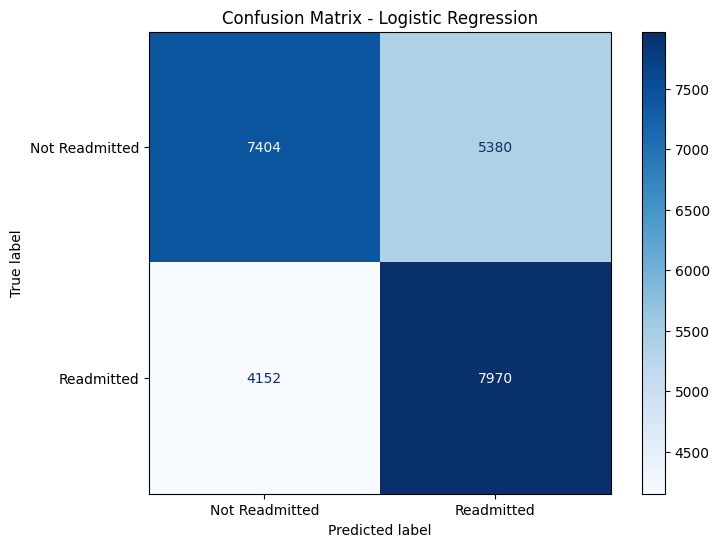

In [69]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Create display with custom class labels: 0 = Not Fraud, 1 = Fraud
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Readmitted', 'Readmitted'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

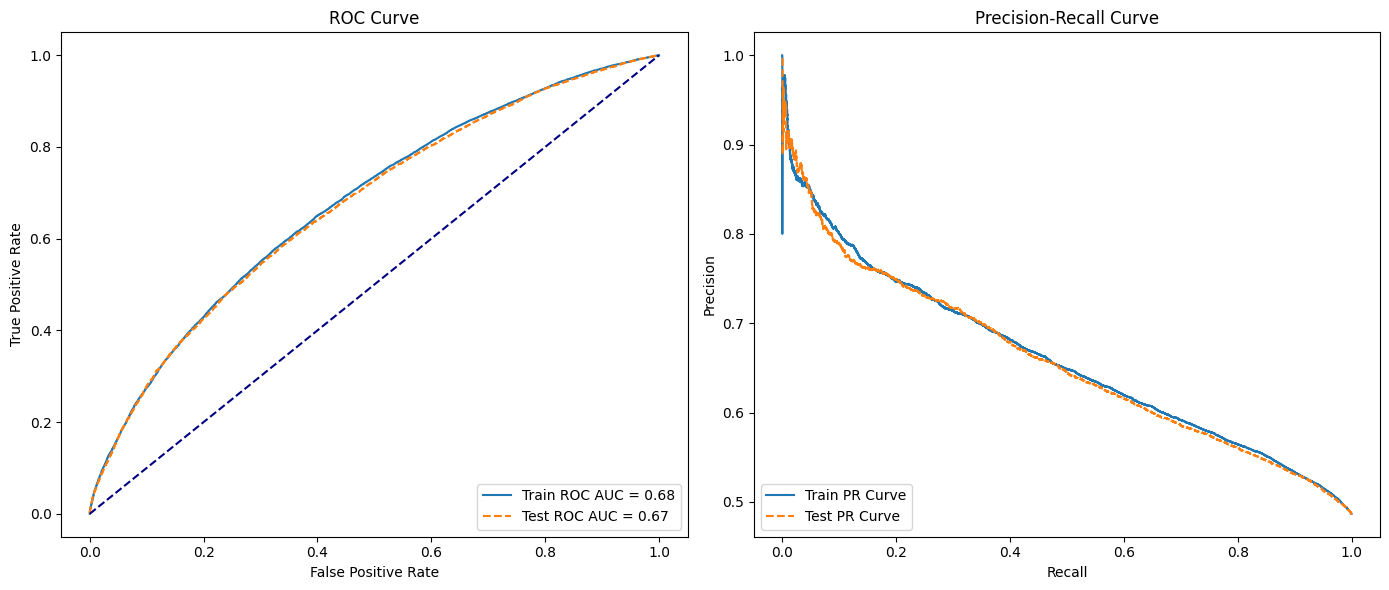

In [88]:
# ROC Curves for Train and Test
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

# Compute AUC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# PR Curves for Train and Test
precision_train, recall_train, _ = precision_recall_curve(y_train, y_prob_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_prob_test)

# Plot ROC and PR curves side-by-side
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {roc_auc_train:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {roc_auc_test:.2f}', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall_train, precision_train, label='Train PR Curve')
plt.plot(recall_test, precision_test, label='Test PR Curve', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [43]:
# feature_importances = model.feature_importances_
# features = X_train.drop(['encounter_id'], axis=1).columns

# # Create a DataFrame to display the feature importances
# importance_df = pd.DataFrame({
#     'Feature': features,
#     'Importance': feature_importances
# }).sort_values(by='Importance', ascending=False)

# print("\nFeature Importances:")
# print(importance_df)

#### Deciles for Test data

In [70]:
lr_probabilities = model.predict_proba(X_test.drop(['encounter_id'], axis=1))[:, 1]
# Step 2: Add the probabilities to the test dataset
X_test['Readmission_Probabilities'] = lr_probabilities

# Step 3: Create deciles using pd.qcut (10 deciles)
X_test['Deciles'] = pd.qcut(X_test['Readmission_Probabilities'].rank(method='first', ascending=False), q=10, labels=range(1, 11))

In [71]:
X_test['Actual_Target'] = y_test
X_test['Predicted_Target'] = y_pred_test

#### Deciles for training data

In [75]:
_trainlr_probabilities = model.predict_proba(X_train.drop(['encounter_id'], axis=1))[:, 1]
# Step 2: Add the probabilities to the test dataset
X_train['Readmission_Probabilities'] = _trainlr_probabilities

# Step 3: Create deciles using pd.qcut (10 deciles)
X_train['Deciles'] = pd.qcut(X_train['Readmission_Probabilities'].rank(method='first', ascending=False), q=10, labels=range(1, 11))

X_train['Actual_Target'] = y_train
X_train['Predicted_Target'] = y_pred_train

In [76]:
# X_test.to_clipboard()
# X_train.to_clipboard()

#### Saving Model

In [72]:
import pickle

model_filename = '../model/lr_model.pkl'

# Saving the model to a file in .pkl format
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as ../model/lr_model.pkl


In [73]:
X_train.columns

Index(['encounter_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses', 'metformin',
       'insulin', 'number_outpatient_log', 'number_inpatient_log',
       'number_emergency_log', 'Patient_Age', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'A1Cresult_>8', 'A1Cresult_No',
       'A1Cresult_Norm', 'change_No', 'diabetesMed_Yes',
       'admission_type_desc_Emergency', 'admission_type_desc_Other',
       'admission_type_desc_Urgent', 'discharge_category_Discharged to Home',
       'discharge_category_Other',
       'discharge_category_Transfers to Other Healthcare Facilities',
       'admission_category_Other', 'admission_category_Physician Referral',
       'admission_category_Transfers from Other Facilities',
       'payer_code_group_Private Insurance', 'payer_code_group_Self-Pay/Other',
       'diag_3_cat_Diabetes', 'diag_3_cat_Digestive',
       'diag_3_cat_Genitourinary', 'diag_3_cat_Injury',
       

#### Saving probabilities with deciles 